Prepare observations: convolution, clip, interpolation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
import matplotlib as mpl
import pickle

import torch
from torch import nn
from torch import optim
from accelerate import Accelerator #to use pytorch
from torch.utils.data import DataLoader

from spender import SpectrumEncoder,MLP,encoder_percentiles,load_model
from tqdm import tqdm,trange

from sbi import utils as Ut
from sbi import inference as Inference

mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['xtick.labelsize'] = 'medium'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'medium'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = True
mpl.rcParams['font.size'] = 30
mpl.rcParams["figure.figsize"] = (15,10)

In [2]:
import os

files= sorted(os.listdir('obs'))[1:]
waves=[]
fluxes=[]
sigma_gal=[]
for f in files:
    data=np.loadtxt('./obs/'+f)
    waves.append(data[:,0])
    fluxes.append(data[:,1])
    arr=np.array([float(f[6:12]),float(f[13:19])])
    sigma_gal.append(np.mean(arr))

In [ ]:
n=len(fluxes)

for i in range(n):
    plt.plot(waves[i],fluxes[i],label='$\\sigma$ = '+str(sigma_gal[i])+' km/s')
plt.ylabel('Flux')
plt.xlabel('Wavelength [$\\AA$]')
plt.legend(fontsize=10)
plt.show()


"""for i in range(n):
    print(np.min(waves[i]),np.max(waves[i]))"""

#largest wavelength range from 4000 to 7400 but we will limit ourselves to the range from 4000 to 5500"

for i in range(n):
    plt.plot(waves[i],fluxes[i],label='$\\sigma$ = '+str(sigma_gal[i])+' km/s')
plt.ylabel('Flux')
plt.xlabel('Wavelength [$\\AA$]')
plt.xlim(4000,5500)
plt.legend(fontsize=10)
plt.show()


In [4]:
fluxes_short=[]
waves_short=[]

for i in range(n):
    ind=np.where((waves[i]>3999)&(waves[i]<7401))[0]
    fluxes_short.append(fluxes[i][ind])
    waves_short.append(waves[i][ind])

In [ ]:
for i in range(n):
    plt.plot(waves_short[i],fluxes_short[i],label='$\\sigma$ = '+str(sigma_gal[i])+' km/s')
plt.ylabel('Flux')
plt.xlabel('Wavelength [$\\AA$]')

plt.legend(fontsize=10)
plt.show()

In [5]:
def gaussian_filter1d(spec, sig):
    """
    Convolve a spectrum by a Gaussian with different sigma for every pixel.
    If all sigma are the same this routine produces the same output as
    scipy.ndimage.gaussian_filter1d, except for the border treatment.
    Here the first/last p pixels are filled with zeros.
    When creating  template library for SDSS data, this implementation
    is 60x faster than a naive for loop over pixels.
    :param spec: vector with the spectrum to convolve
    :param sig: vector of sigma values (in pixels) for every pixel
    :return: spec convolved with a Gaussian with dispersion sig
    """
    sig = sig.clip(0.01)  # forces zero sigmas to have 0.01 pixels
    p = int(np.ceil(np.max(3*sig)))
    m = 2*p + 1  # kernel size
    x2 = np.linspace(-p, p, m)**2
    n = spec.size
    a = np.zeros((m, n))
    for j in range(m):   # Loop over the small size of the kernel
        a[j, p:-p] = spec[j:n-m+j+1]
    gau = np.exp(-x2[:, None]/(2*sig**2))
    gau /= np.sum(gau, 0)[None, :]  # Normalize kernel
    conv_spectrum = np.sum(a*gau, 0)
    return conv_spectrum

$$ \sigma_{gal}^2=\sigma_{v}^2+\sigma_{ins}^2$$

We are going to convert all of them to $v=300$ km/s, so:

$$ \sigma_{diff}^2 = \sigma_{300}^2+\sigma_{ins}^2 - (\sigma_{gal}^2+\sigma_{ins}^2) = \sigma_{300}^2 - \sigma_{gal}^2   $$

And to move from velocity dispersion to kernel width, we will need:

$$
\mathrm{FWHM}=2 \sqrt{2 \ln 2} \sigma \approx 2.35482 \sigma
$$

In [6]:
cvel=300000 #km/s

"""for i in range(n):
    print(waves_short[i],waves_short[i][1]-waves_short[i][0]) #psize=1 A
"""
psize=1
fluxes_conv=[]
max_sigma=np.sqrt(300**2 - np.array(sigma_gal)**2) #velocity dispersion

for i in trange(n):
    FWHM_gal = 2.*np.sqrt(2.*np.log(2.)) * max_sigma[i] / cvel * waves_short[i]
    FWHM_dif = np.sqrt(FWHM_gal**2)
    sigma = FWHM_dif/(psize*2.*np.sqrt(2.*np.log(2.))) # Sigma difference in pixels, for the kernel
    flux_conv = gaussian_filter1d(fluxes_short[i], sigma) 
    fluxes_conv.append(flux_conv)

100%|██████████| 18/18 [00:00<00:00, 182.55it/s]


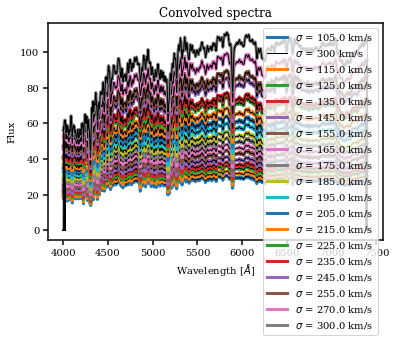

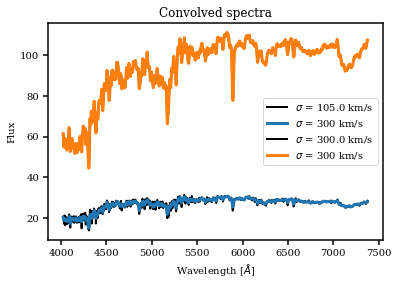

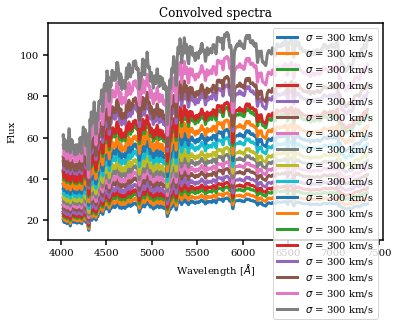

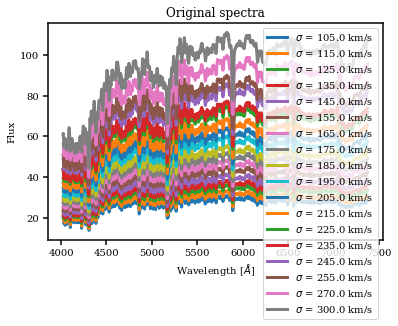

In [7]:
for i in range(n): 
    plt.plot(waves_short[i],fluxes_short[i],label='$\\sigma$ = '+str(sigma_gal[i])+' km/s',lw=3)
    if i==0:
        plt.plot(waves_short[i],fluxes_conv[i],label='$\\sigma$ = '+str(300)+' km/s',c='k',lw=1)
    else:
        plt.plot(waves_short[i],fluxes_conv[i],c='k',lw=1)

plt.ylabel('Flux')
plt.xlabel('Wavelength [$\\AA$]')
plt.title('Convolved spectra')
plt.legend(fontsize=10)
plt.show()


for i in [0,-1]:
    plt.plot(waves_short[i][23:3378],fluxes_short[i][23:3378],label='$\\sigma$ = '+str(sigma_gal[i])+' km/s',c='k',lw=2)
    plt.plot(waves_short[i][23:3378],fluxes_conv[i][23:3378],label='$\\sigma$ = '+str(300)+' km/s',lw=3)
    
plt.ylabel('Flux')
plt.xlabel('Wavelength [$\\AA$]')
plt.title('Convolved spectra')
plt.legend(fontsize=10)
plt.show()


for i in range(n):
    plt.plot(waves_short[i][23:3378],fluxes_conv[i][23:3378],label='$\\sigma$ = '+str(300)+' km/s',lw=3)
    
plt.ylabel('Flux')
plt.xlabel('Wavelength [$\\AA$]')
plt.title('Convolved spectra')
plt.legend(fontsize=10)
plt.show()

for i in range(n):
    plt.plot(waves_short[i][23:3378],fluxes_short[i][23:3378],label='$\\sigma$ = '+str(sigma_gal[i])+' km/s',lw=3)
    
plt.ylabel('Flux')
plt.xlabel('Wavelength [$\\AA$]')
plt.title('Original spectra')
plt.legend(fontsize=10)
plt.show()

In [8]:
#print(fluxes_conv[0][:20])
#print(waves_short[0][:20])
#print(fluxes_conv[0][-30:])
#print(waves_short[0][-30:])

print('First index non zero: ',np.where(fluxes_conv[0]>0)[0][0])
print('Last index non zero: ',np.where(fluxes_conv[0]>0)[0][-1])

print('First index non zero: ',np.where(fluxes_conv[-1]>0)[0][0])
print('Last index non zero: ',np.where(fluxes_conv[-1]>0)[0][-1])


print('Valid wavelength range: ', np.min(waves_short[0][23:3378]),np.max(waves_short[0][23:3378]))

waves_short_2 = []
fluxes_conv_2 = []

print('Selected wavelength range: ',waves_short[0][23],waves_short[0][2000])

for i in range(n):
    waves_short_2.append(waves_short[i][23:2001])
    fluxes_conv_2.append(fluxes_conv[i][23:2001])

First index non zero:  21
Last index non zero:  3379
First index non zero:  1
Last index non zero:  3399
Valid wavelength range:  4023.0 7377.0
Selected wavelength range:  4023.0 6000.0


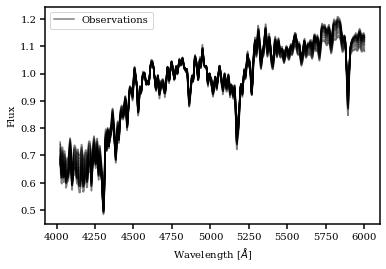

In [9]:

#observations
for i in range(n):
    if i==0:
        plt.plot(waves_short_2[i],fluxes_conv_2[i]/np.median(fluxes_conv_2[i]),'k',label='Observations',alpha=0.5)
    else:
        plt.plot(waves_short_2[i],fluxes_conv_2[i]/np.median(fluxes_conv_2[i]),'k',alpha=0.5)
        
    
plt.ylabel('Flux')
plt.xlabel('Wavelength [$\\AA$]')
plt.legend()
plt.show()

#observations are really old galaxies as we see

In [ ]:
#single observation each time


    
#observations
for i in range(4):

    if i==0:
        plt.plot(waves_short_2[i],fluxes_conv_2[i]/np.median(fluxes_conv_2[i]),'k',label='Observations')
    else:
        plt.plot(waves_short_2[i],fluxes_conv_2[i]/np.median(fluxes_conv_2[i]),'k')
        
    plt.ylabel('Flux')
    plt.xlabel('Wavelength [$\\AA$]')
    plt.legend()
    plt.show()

#observations are really old galaxies as we see

In [11]:
print(waves_short_2[0])
print(waves_short_2[-1])

#delta lambda MILES = 0.9 A
#delta lambda Observations = 1 A
#Interpolamos para pasar MILES a 1 Amstrong



[4023. 4024. 4025. ... 5998. 5999. 6000.]
[4023. 4024. 4025. ... 5998. 5999. 6000.]


In [14]:
#SAVE


seds=[]
for i in range(18):
    seds.append(fluxes_conv_2[i]/np.median(fluxes_conv_2[i]))

np.save('./obs/processed/seds.npy',seds)

np.save('./obs/processed/wave.npy',waves_short_2[0])



In [3]:
seds=np.load('./obs/processed/seds.npy')

Let's start predicting

In [4]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self,x):

        """ generate and organize artificial data from parametrizations of SFHs"""

        self.x=torch.from_numpy(x) #seds
        

    def __len__(self):
        """total number of samples"""
        return len(self.x[:,0])

    def __getitem__(self,index):
        """Generates one sample of data"""
        x=self.x[index,:]
        return x


In [5]:
#create a pytorch dataset

dataset = Dataset(np.array(seds) )
params={'batch_size': 1 } 
generator = torch.utils.data.DataLoader(dataset,**params) #without minibatches

#call accelerator
accelerator = Accelerator(mixed_precision='fp16')
loader = accelerator.prepare(generator)

#load model
n_latent=16
model_file = "./saved_models/checkpoint.pt"
model, loss = load_model(model_file, device=accelerator.device,n_hidden=(16,32),n_out=10)
model = accelerator.prepare(model)
        
#predict
ss=[]
ys_=[]
print('Getting latent vectors and predicted percentiles')
with torch.no_grad():
    model.eval()
    for  batch in tqdm(loader):
                s,y_ = model._forward(batch.float())
                ss.append(s.cpu().numpy())
                ys_.append(y_.cpu().numpy())

ss=np.array(ss)[:,0,:]

Getting latent vectors and predicted percentiles


100%|██████████| 18/18 [00:01<00:00, 12.99it/s]


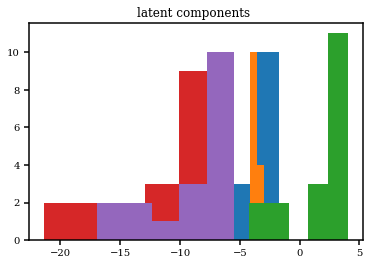

(18, 16)


In [8]:
for i in range(5):#16):
    plt.hist(ss[:,i],bins=5,label='l'+str(i+1))
plt.title('latent components ')
plt.show()

print(np.shape(ss))

In [6]:
file="./saved_models/my_posterior.pkl"

file = open(file, 'rb')
qphi = pickle.load(file)
file.close()

posteriors=[]


for i in trange(18):
    posteriors.append(np.array(qphi.sample((1000,), 
                                     x=torch.as_tensor(ss[i,:]).to('cpu'), 
                                     show_progress_bars=False).detach().to('cpu')))
posteriors=np.array(posteriors)

 83%|████████▎ | 15/18 [03:14<01:39, 33.06s/it]WARNING:root:Only 0.409% proposal samples are
                    accepted. It may take a long time to collect the remaining
                    955 samples. Consider interrupting (Ctrl-C) and switching to
                    `build_posterior(..., sample_with='mcmc')`.
 83%|████████▎ | 15/18 [05:38<01:07, 22.56s/it]


KeyboardInterrupt: 

In [ ]:
np.save('post_obs_median.npy',np.median(posteriors,axis=1))
np.save('post_obs_stds.npy',np.std(posteriors,axis=1))

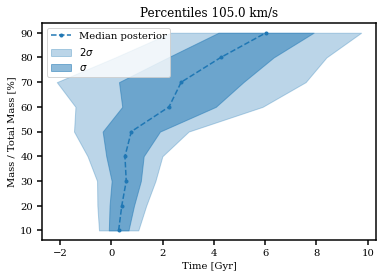

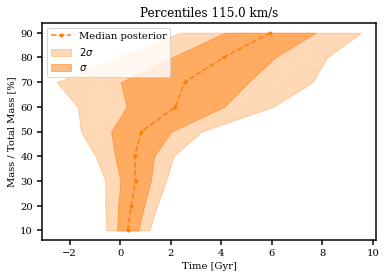

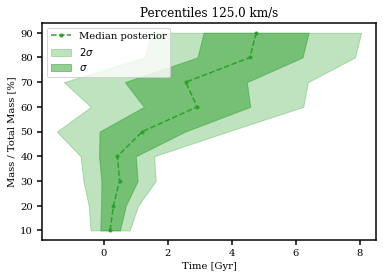

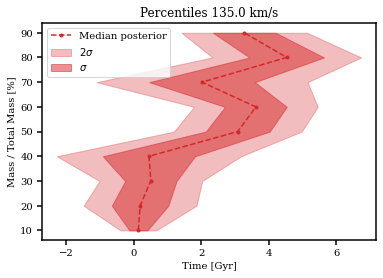

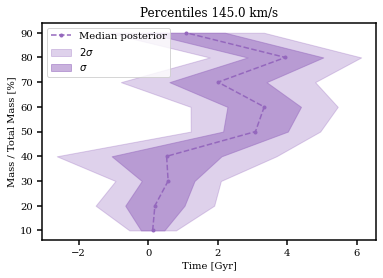

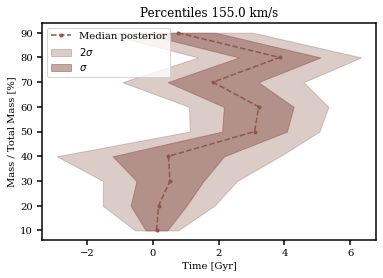

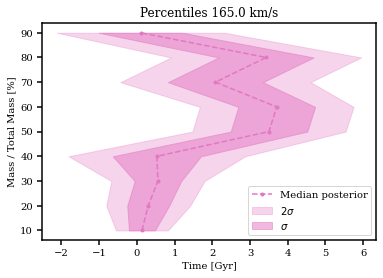

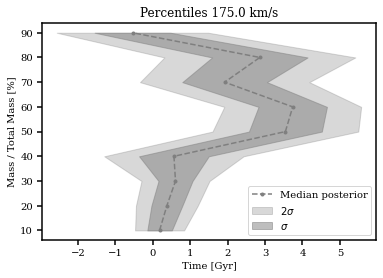

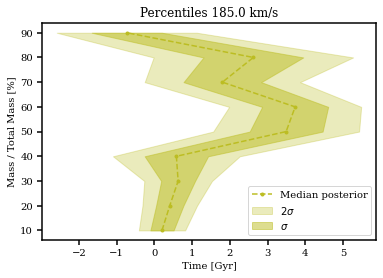

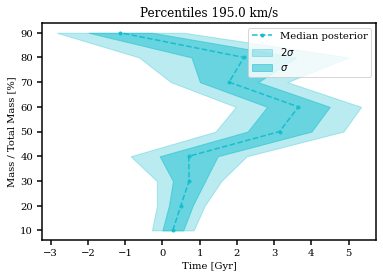

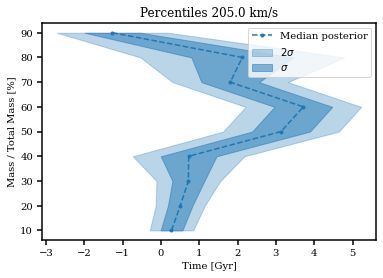

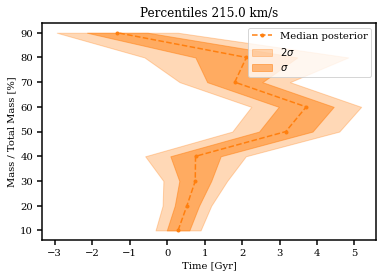

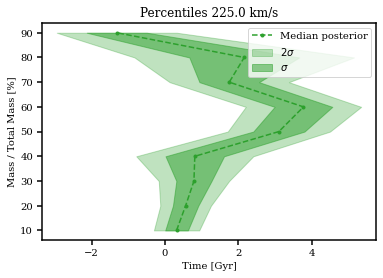

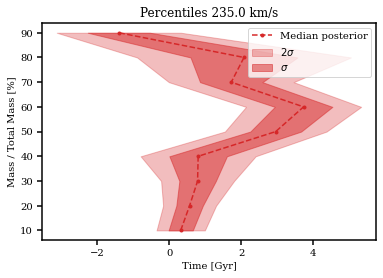

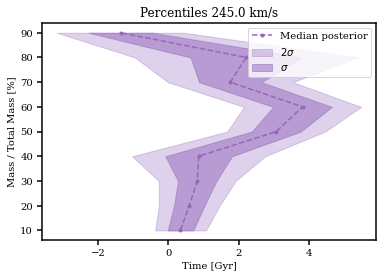

KeyboardInterrupt: 

In [7]:
def plot_percentile_distribution(index_list=range(18),mean=False,real_plot=False):
    
    for k,j in enumerate(index_list):
                
                Xobs=ss[j,:]
                posterior_samples= 
                
                """np.array(qphi.sample((1000,), 
                                                    x=torch.as_tensor(np.array([Xobs]).astype(np.float32)).to('cpu'), 
                                                        show_progress_bars=False).detach().to('cpu'))"""
                
                plt.plot(np.median(posterior_samples,axis=0)[:9],np.arange(10,100,10),'.--',color='C'+str(k),label='Median posterior')
                plt.fill_betweenx(np.arange(10,100,10),np.median(posterior_samples,axis=0)[:9]+2*np.std(posterior_samples[:,:9],axis=0),np.median(posterior_samples,axis=0)[:9]-2*np.std(posterior_samples[:,:9],axis=0),color='C'+str(k),alpha=0.3,label='$2\\sigma$')
                plt.fill_betweenx(np.arange(10,100,10),np.median(posterior_samples,axis=0)[:9]+np.std(posterior_samples[:,:9],axis=0),np.median(posterior_samples,axis=0)[:9]-np.std(posterior_samples[:,:9],axis=0),color='C'+str(k),alpha=0.5,label='$\\sigma$')
                plt.title('Percentiles '+str(sigma_gal[k])+' km/s')
                plt.legend()
                plt.xlabel('Time [Gyr]')
                plt.ylabel('Mass / Total Mass [%]')
                #plt.savefig('prediction_'+str(k)+'.jpg')
                plt.show()

    

plot_percentile_distribution()

In [9]:
import os

files= sorted(os.listdir('ppxf_obs_predictions'))
print(files)
ages=[]
weights=[]
for f in files[:]:
    data=np.loadtxt('./ppxf_obs_predictions/'+f)
    ages.append(14-data[:,0])
    weights.append(data[:,1])

np.save('ages_ppxf.npy',ages)
np.save('weights_ppxf.npy',weights)

['Ages_weights_100.00_110.00.dat', 'Ages_weights_110.00_120.00.dat', 'Ages_weights_120.00_130.00.dat', 'Ages_weights_130.00_140.00.dat', 'Ages_weights_140.00_150.00.dat', 'Ages_weights_150.00_160.00.dat', 'Ages_weights_160.00_170.00.dat', 'Ages_weights_170.00_180.00.dat', 'Ages_weights_180.00_190.00.dat', 'Ages_weights_190.00_200.00.dat', 'Ages_weights_200.00_210.00.dat', 'Ages_weights_210.00_220.00.dat', 'Ages_weights_220.00_230.00.dat', 'Ages_weights_230.00_240.00.dat', 'Ages_weights_240.00_250.00.dat', 'Ages_weights_250.00_260.00.dat', 'Ages_weights_260.00_280.00.dat', 'Ages_weights_280.00_320.00.dat']


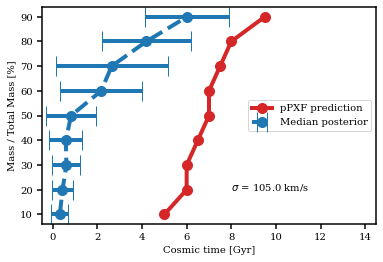

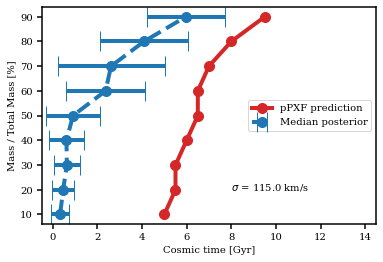

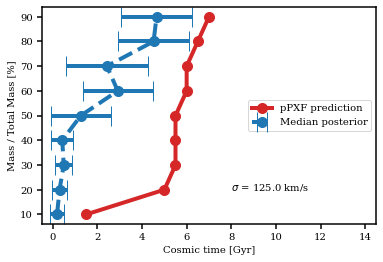

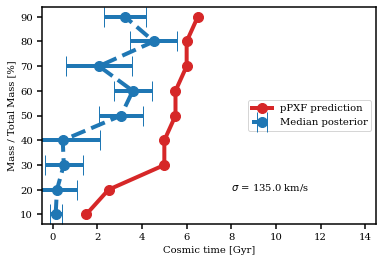

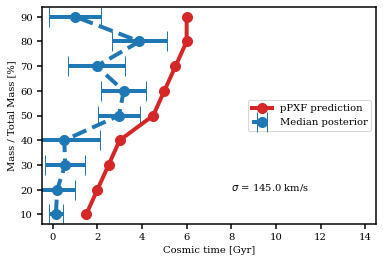

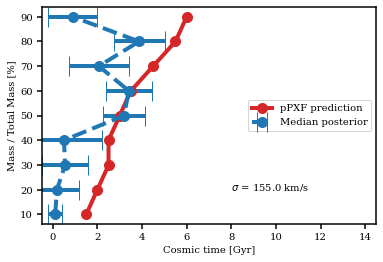

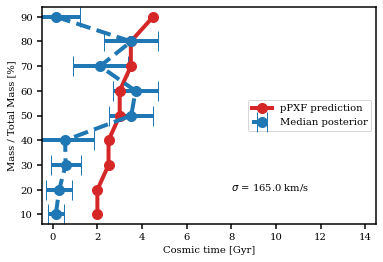

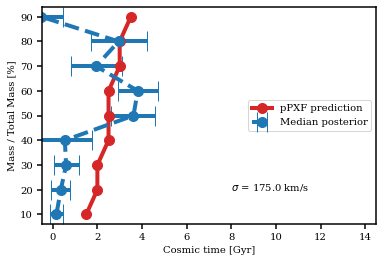

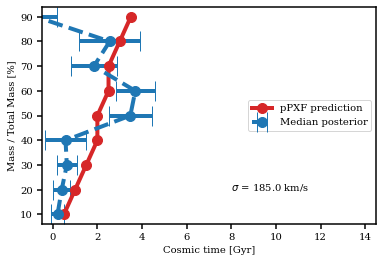

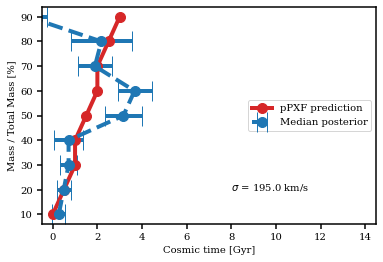

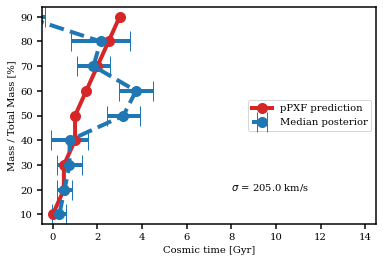

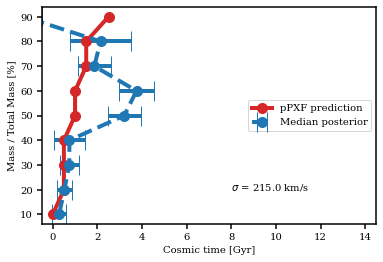

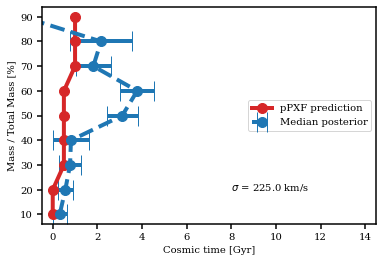

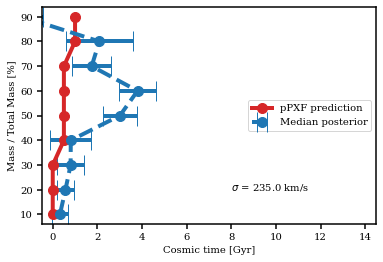

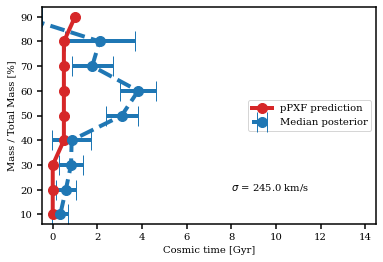

                    accepted. It may take a long time to collect the remaining
                    945 samples. Consider interrupting (Ctrl-C) and switching to
                    `build_posterior(..., sample_with='mcmc')`.


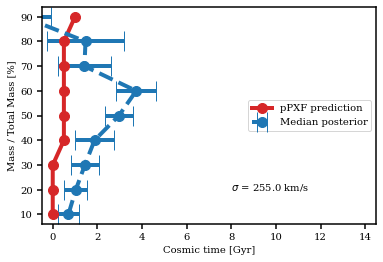

                    accepted. It may take a long time to collect the remaining
                    938 samples. Consider interrupting (Ctrl-C) and switching to
                    `build_posterior(..., sample_with='mcmc')`.


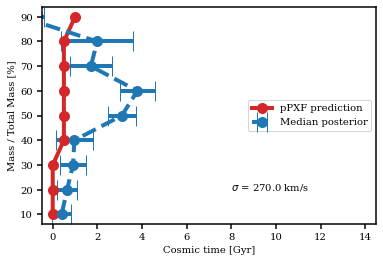

                    accepted. It may take a long time to collect the remaining
                    936 samples. Consider interrupting (Ctrl-C) and switching to
                    `build_posterior(..., sample_with='mcmc')`.


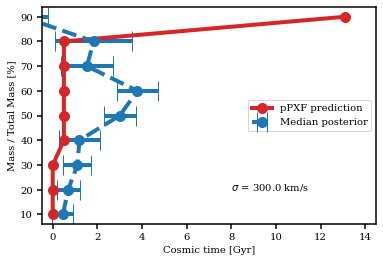

In [10]:
def plot_observations(index_list=range(18),ppxf=True):
    percent_ppxf=[]
    for k,j in enumerate(index_list):
        Xobs=ss[j,:]
        posterior_samples= np.array(qphi.sample((1000,), 
                                            x=torch.as_tensor(np.array([Xobs]).astype(np.float32)).to('cpu'), 
                                                show_progress_bars=False).detach().to('cpu'))
        
        plt.errorbar(np.median(posterior_samples,axis=0)[:9],np.arange(10,100,10),xerr=np.std(posterior_samples[:,:9],axis=0),fmt='o--',color='tab:blue',label='Median posterior',lw=4,ms=10,capsize=10)


        
        mcurve=weights[k]
        m=[]
        percent=[]
        for a in range(len(mcurve)):
            m.append(np.sum(mcurve[:a+1]))
        for b in range(1,10):
            ind=np.argmin(abs(np.array(m)-b/10))
            percent.append(ages[k][ind])
        plt.plot(percent,np.arange(10,100,10)[::-1],'-o',label='pPXF prediction',c='tab:red',lw=4,ms=10)
        percent_ppxf.append(percent)


        plt.text(8,20, '$\\sigma$ = '+str(sigma_gal[k])+' km/s')
        plt.legend(loc='center right')
        plt.xlabel('Cosmic time [Gyr]')
        plt.ylabel('Mass / Total Mass [%]')
        plt.xlim(-0.5,14.5)
        #plt.savefig('prediction_'+str(k)+'.jpg')
        plt.show()

    return percent_ppxf

    

percent_ppxf=plot_observations()
    
    

In [10]:
print(np.shape(posteriors))

means=np.mean(posteriors,axis=1)
stds=np.std(posteriors,axis=1)
print(np.shape(means))



(18, 1000, 10)
(18, 10)


In [11]:
delta_t=0.01348046441147335
ms_from_percentiles=[]
ms_from_percentiles_ppxf=[]
for i in trange(18):
    per=means[i,:9]
    per_ppxf=percent_ppxf[i][::-1]
    ms=np.gradient(np.arange(0.1,1,0.1),per) #unit Msun/gyr
    ms_from_percentiles.append(ms*delta_t) #unit Msun
    ms_ppxf=np.gradient(np.arange(0.1,1,0.1),per_ppxf) #unit Msun/gyr
    ms_from_percentiles_ppxf.append(ms_ppxf*delta_t) 
ms_from_percentiles=np.array(ms_from_percentiles)


ms_from_percentiles_std=[]
for i in trange(18):
    per=means[i,:9]+stds[i,:9]
    ms=np.gradient(np.arange(0.1,1,0.1),per) #unit Msun/gyr
    ms_from_percentiles_std.append(ms*delta_t) #unit Msun
ms_from_percentiles_std=np.array(ms_from_percentiles_std)

ms_from_percentiles_std_=[]
for i in trange(18):
    per=means[i,:9]-stds[i,:9]
    ms=np.gradient(np.arange(0.1,1,0.1),per) #unit Msun/gyr
    ms_from_percentiles_std_.append(ms*delta_t) #unit Msun
ms_from_percentiles_std_=np.array(ms_from_percentiles_std_)

  0%|          | 0/18 [00:00<?, ?it/s]/Users/patriglesiasnavarro/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:1215: RuntimeWarning: divide by zero encountered in true_divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
/Users/patriglesiasnavarro/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:1216: RuntimeWarning: divide by zero encountered in true_divide
  b = (dx2 - dx1) / (dx1 * dx2)
/Users/patriglesiasnavarro/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:1217: RuntimeWarning: divide by zero encountered in true_divide
  c = dx1 / (dx2 * (dx1 + dx2))
/Users/patriglesiasnavarro/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:1223: RuntimeWarning: invalid value encountered in add
  out[tuple(slice1)] = a * f[tuple(slice2)] + b * f[tuple(slice3)] + c * f[tuple(slice4)]
/Users/patriglesiasnavarro/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:1215: RuntimeWarning: invalid value encountered 

[5.0, 6.0, 6.0, 6.5, 7.0, 7.0, 7.5, 8.0, 9.5]


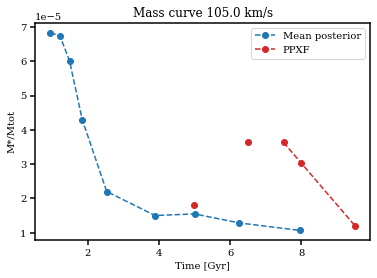

[5.0, 5.5, 5.5, 6.0, 6.5, 6.5, 7.0, 8.0, 9.5]


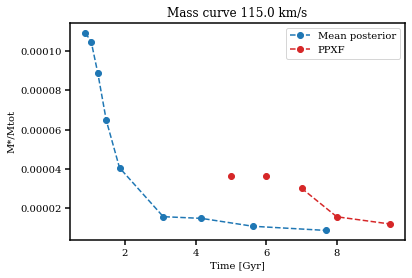

[1.5, 5.0, 5.5, 5.5, 5.5, 6.0, 6.0, 6.5, 7.0]


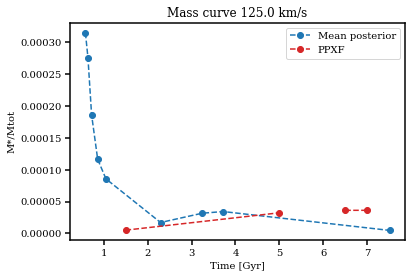

[1.5, 2.5, 5.0, 5.0, 5.5, 5.5, 6.0, 6.0, 6.5]


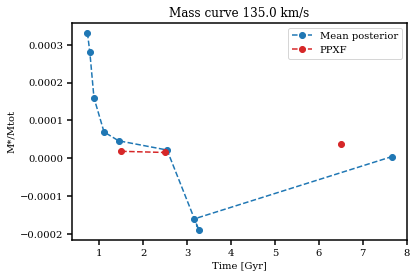

[1.5, 2.0, 2.5, 3.0, 4.5, 5.0, 5.5, 6.0, 6.0]


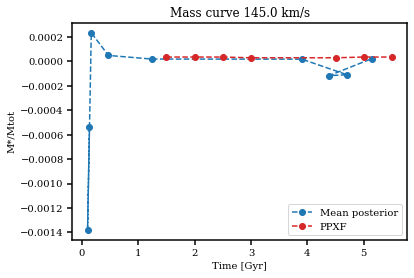

[1.5, 2.0, 2.5, 2.5, 3.0, 3.5, 4.5, 5.5, 6.0]


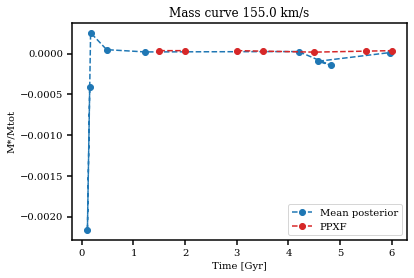

[2.0, 2.0, 2.5, 2.5, 3.0, 3.0, 3.5, 3.5, 4.5]


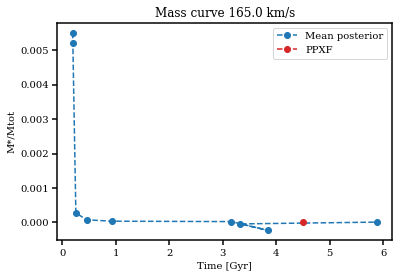

[1.5, 2.0, 2.0, 2.5, 2.5, 2.5, 3.0, 3.0, 3.5]


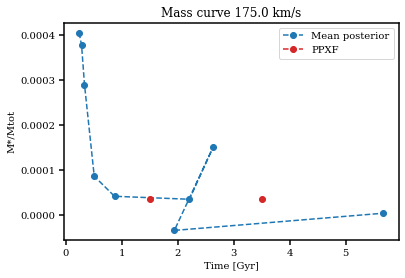

[0.5, 1.0, 1.5, 2.0, 2.0, 2.5, 2.5, 3.0, 3.5]


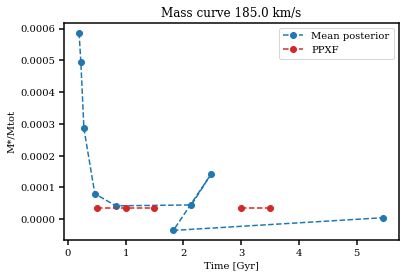

[0.0, 0.5, 1.0, 1.0, 1.5, 2.0, 2.0, 2.5, 3.0]


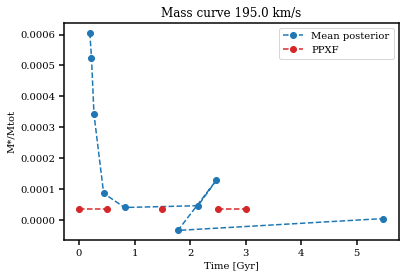

[0.0, 0.5, 0.5, 1.0, 1.0, 1.5, 2.0, 2.5, 3.0]


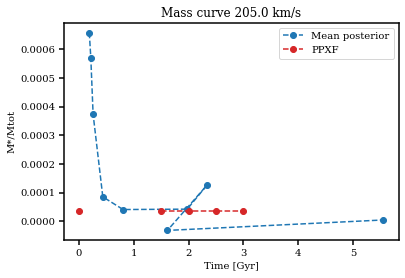

[0.0, 0.5, 0.5, 0.5, 1.0, 1.0, 1.5, 1.5, 2.5]


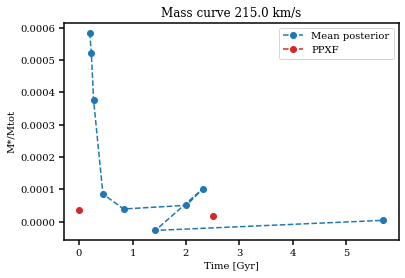

[0.0, 0.0, 0.5, 0.5, 0.5, 0.5, 1.0, 1.0, 1.0]


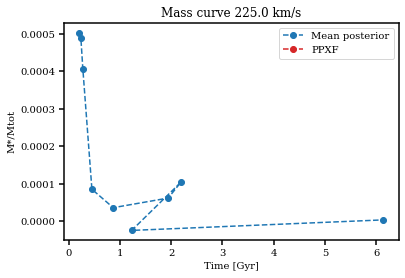

[0.0, 0.0, 0.0, 0.5, 0.5, 0.5, 0.5, 1.0, 1.0]


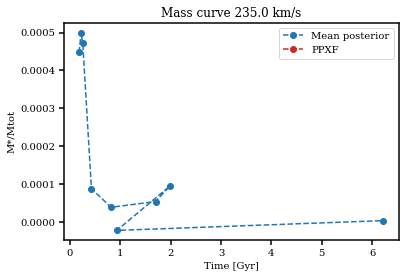

[0.0, 0.0, 0.0, 0.5, 0.5, 0.5, 0.5, 0.5, 1.0]


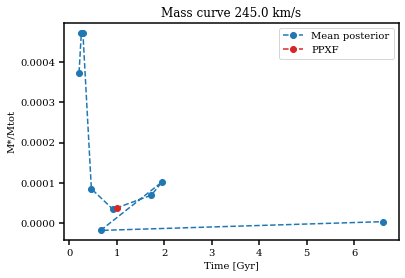

[0.0, 0.0, 0.0, 0.5, 0.5, 0.5, 0.5, 0.5, 1.0]


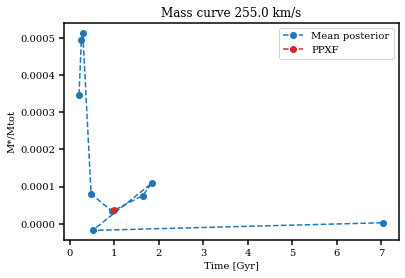

[0.0, 0.0, 0.0, 0.5, 0.5, 0.5, 0.5, 0.5, 1.0]


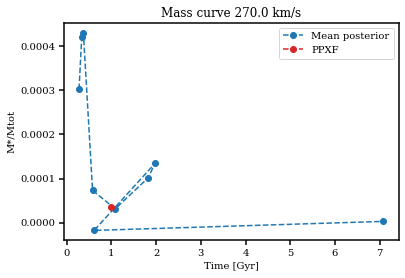

[0.0, 0.0, 0.0, 0.5, 0.5, 0.5, 0.5, 0.5, 13.1]


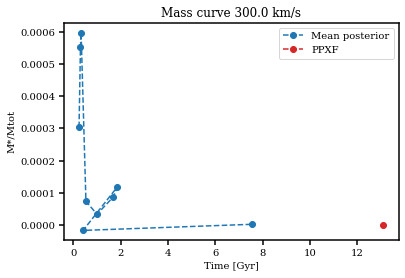

In [12]:
for i in range(18):
    ms=ms_from_percentiles[i]
    per=means[i,:9]
    ms_ppxf=ms_from_percentiles_ppxf[i]
    per_ppxf=percent_ppxf[i][::-1]
    print(per_ppxf)
    plt.plot(per,ms*delta_t,'o--',color='tab:blue',label='Mean posterior')
    plt.plot(per_ppxf,ms_ppxf*delta_t,'o--',color='tab:red',label='PPXF')
    plt.title('Mass curve '+str(sigma_gal[i])+' km/s')
    plt.xlabel('Time [Gyr]')
    plt.ylabel('M*/Mtot')
    plt.legend()
    #plt.savefig('./plots/mass_curve_'+str(i)+'.jpg')
    plt.show()

In [ ]:
for i in range(10):
    for j in range(18):
        plt.hist(posteriors[j,:,i])
    plt.show()

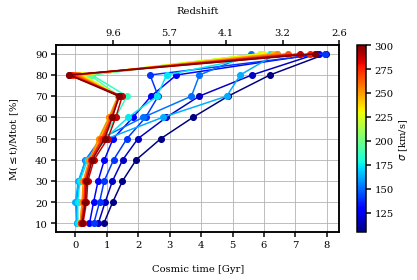

In [16]:
import astropy.units as u
from astropy.cosmology import  Planck13,z_at_value



def z(t):
    #receives cosmic time, returns redshit
    return np.around(z_at_value(Planck13.age,t*u.Gyr).value,1)
    
    

def t(z):
    #receives redsfit, returns cosmic time
    return (Planck13.age(0)-Planck13.lookback_time(z)).value
    
colors=plt.cm.jet(np.linspace(0,1,18))
fig,ax=plt.subplots()
for k,j in enumerate(range(18)):
                
    Xobs=ss[j,:]
    posterior_samples= np.array(qphi.sample((1000,), 
                                        x=torch.as_tensor(np.array([Xobs]).astype(np.float32)).to('cpu'), 
                                            show_progress_bars=False).detach().to('cpu'))
    
    ax.plot(np.median(posterior_samples,axis=0)[:9],np.arange(10,100,10),'o-',color=colors[k])
    plt.scatter(np.median(posterior_samples,axis=0)[:9],np.arange(10,100,10),marker='None',c=sigma_gal[k]*np.ones((9,)),cmap='jet')
    
#plt.title('Percentiles galaxies'+'\n')

plt.xlabel('\n'+'Cosmic time [Gyr]')
plt.ylabel('M($\leq$t)/Mtot [%]'+'\n')
ax2 = ax.twiny()
xt=np.arange(0.001,2.61,0.5)
xl=z(xt)
ax2.set_xticks(xt[1:],labels=xl[1:])
ax2.set_xlabel('Redshift'+'\n')
#ax.legend(bbox_to_anchor=(1, 0.5))
#ax.set_xlim(0,2.5)
ax.set_yticks(np.arange(10,100,10))
ax.grid()
fig.tight_layout()    
plt.colorbar(label='$\\sigma$ [km/s]')
plt.clim(105,300)
#plt.savefig('pred_gal_full.jpg')
plt.show()